In [12]:
%run '/home/christianl/Zhang-Lab/Zhang Lab Code/Boilerplate_datahandling/Remote boilerplate/Fig_config_utilities.py'

<class 'numpy.ndarray'> (3187, 16101)
<class 'numpy.ndarray'> (3187, 16101)
LOADING MODEL - EXACT TRAINING SCRIPT SEQUENCE

1. Loading checkpoint from: /home/christianl/Zhang-Lab/Zhang Lab Data/Saved models/RNN/uncentered_data_RNN/signaling_model.v1.pt

2. Loading network from: /home/christianl/Zhang-Lab/Zhang Lab Data/Full data files/network(full).tsv
   Network shape: (1153904, 3)
   Network columns: ['TF', 'Gene', 'Interaction']

3. Formatting network...

4. Using EXACT benchmark.py parameters
   projection_amplitude_in: 1.2
   projection_amplitude_out: 1.2
   bionet_params: {'target_steps': 150, 'max_steps': 10, 'exp_factor': 50, 'tolerance': 1e-20, 'leak': 0.01}

5. Initializing model with DataFrames...
   Input X_in shape: (3187, 1198)
   Input y_out shape: (3187, 16101)
  Filtered X_in: 1198 → 1197 features
  Filtered y_out: 16101 → 16100 features
   ✓ Model initialized (data automatically filtered)

6. Converting DataFrames to tensors...
   ✓ Tensors created

7. Applying traini

RuntimeError: The size of tensor a (1197) must match the size of tensor b (1198) at non-singleton dimension 1

In [ ]:
# diagnostics of MLR r2 scores

print("y_test shape:", y_test_centered.shape)
print("y_pred_mlr shape:", mlr_y_pred.shape)

# verify they match (they do)
# y_test_centered shape: (3187, 16101)
# y_pred_mlr shape: (3187, 16101)
assert y_test_centered.shape == mlr_y_pred.shape

# compare r2 values
# .score() r2 is the variance-weighted r2, which computes each gene's r2 individually (genes are treated differently) 
# as each gene predictions are still in 2D Numpy arrays not flattened
# reg_loaded.score: 0.7934193600256717
print("mlr_loaded.score:", mlr_loaded.score(x_test_centered, y_test_centered))

# compute_metrics() is the flattened r2, where each gene's r2 is treated equally (flattened) before aggregating
# compute_metrics r2: 0.8463157210258276
# compute_metrics r2 > .score() r2 -> figured out that .score() when unspecified does uniform-average, different to compute_metrics r2 
# which calculates the variance-weighted r2, taking into account the individual variances of each gene.
# given the difference of 0.365 between the two, positive correlation between variance and R2 indicates that model performs better
# on genes with higher variance (more distinct expression patterns) than lower variance ones (ie. housekeeping, "silenced", etc.)
metrics_flat_mlr = compute_metrics(y_test_centered, mlr_y_pred)
print("compute_metrics r2:", metrics_flat_mlr['r2'])

# compute_metrics_per_gene() looks at the indiviudal r2 at per-gene resolution (for extra context not hugely meaningful)
metrics_flat_per_gene_mlr = compute_metrics_per_gene(y_test_centered, mlr_y_pred)
print("compute_metrics_per_gene r2:", metrics_flat_per_gene_mlr['r2'])

y_test shape: (3187, 16101)
y_pred_mlr shape: (3187, 16101)


mlr_loaded.score: 0.7934193600256717
compute_metrics r2: 0.8463157210258276
compute_metrics_per_gene r2: 0        1.000000
1        0.857101
2        0.726797
3        0.287946
4        0.767382
           ...   
16096    0.776810
16097    0.883082
16098    0.924978
16099    0.907058
16100    0.893114
Name: r2, Length: 16101, dtype: float64


In [2]:
# same diagnostics for XGBRF.v3 (trained on x_train_centered)

print("y_pred_xgbrf shape:", xgbrf_y_pred.shape)
print("xgbrf_loaded.score:", xgbrf_loaded.score(x_test_centered, y_test_centered))

metrics_flat_xgbrf = compute_metrics(y_test_centered, xgbrf_y_pred)
print("compute_metrics r2:", metrics_flat_xgbrf['r2'])

metrics_flat_per_gene_xgbrf = compute_metrics_per_gene(y_test_centered, xgbrf_y_pred)
print("compute_metrics_per_gene r2:", metrics_flat_per_gene_xgbrf['r2'])

y_pred_xgbrf shape: (3187, 16101)


xgbrf_loaded.score: 0.7599449659557176
compute_metrics r2: 0.8050248679702268
compute_metrics_per_gene r2: 0        0.997834
1        0.813377
2        0.699476
3        0.316923
4        0.725691
           ...   
16096    0.692630
16097    0.826207
16098    0.883766
16099    0.868933
16100    0.858181
Name: r2, Length: 16101, dtype: float64


In [3]:
# observed vs. expected prediction scatterplots with Pearson's R
def figure_1_observed_vs_predicted(y_true, predictions_dict, 
                                  r2_method='variance_weighted',
                                  output_path='~/Zhang-Lab/Zhang Lab Data/Saved figures/'):
    """
    Generate observed vs. predicted scatterplot with Pearson correlation.
    
    Parameters
    ----------
    y_true : array-like, shape (n_samples, n_genes)
        True target gene expression values
    predictions_dict : dict
        Dictionary with keys as model names and values as predictions
        Example: {'RNN': pred_rnn, 'XGBRFRegressor': pred_xgb, 'Linear': pred_linear}
    r2_method : str, default='variance_weighted'
        Method for computing R² in multi-output setting:
        - 'variance_weighted': Weight genes by their variance (default sklearn behavior for flattened)
        - 'uniform_average': Simple mean of per-gene R² (default sklearn .score() behavior)
        - 'flattened': Explicitly compute on flattened data (same as variance_weighted)
    output_path : str
        Path to save figure
    """
    set_publication_style()
    fig, axes = plt.subplots(1, 3, figsize=FIGSIZE_TRIPLE)
    model_names = list(predictions_dict.keys())
    
    for idx, model_name in enumerate(model_names):
        ax = axes[idx]
        y_pred = predictions_dict[model_name]
        
        # Flatten arrays for scatter plot
        y_true_flat = y_true.ravel()
        y_pred_flat = y_pred.ravel()
        
        # Compute metrics based on specified method
        if r2_method == 'variance_weighted' or r2_method == 'flattened':
            # Compute R² on flattened data (equivalent to variance-weighted)
            r2 = r2_score(y_true_flat, y_pred_flat)
            r2_label = "R² (variance-weighted)"
        elif r2_method == 'uniform_average':
            # Compute mean of per-gene R²
            r2 = r2_score(y_true, y_pred, multioutput='uniform_average')
            r2_label = "R² (uniform average)"
        else:
            raise ValueError(f"Unknown r2_method: {r2_method}")
        
        # Pearson correlation (always on flattened data for scatter plot)
        pearson_r, p_value = pearsonr(y_true_flat, y_pred_flat)
        
        # Scatter plot
        ax.scatter(y_true_flat, y_pred_flat, alpha=0.5, s=30, 
                   color=MODEL_COLORS.get(model_name, '#1f77b4'),
                   edgecolors='none')
        
        # Perfect prediction diagonal line
        min_val = min(y_true_flat.min(), y_pred_flat.min())
        max_val = max(y_true_flat.max(), y_pred_flat.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'k--', 
                lw=2, alpha=0.5, label='Perfect prediction')
        
        # Fit regression line
        z = np.polyfit(y_true_flat, y_pred_flat, 1)
        p = np.poly1d(z)
        x_line = np.linspace(y_true_flat.min(), y_true_flat.max(), 100)
        y_line = p(x_line)
        ax.plot(x_line, y_line, color=MODEL_COLORS.get(model_name, '#1f77b4'),
                lw=2.5, alpha=0.8, label='Linear fit')
        
        # Labels and formatting
        ax.set_xlabel('Observed Expression', fontsize=12, fontweight='bold')
        ax.set_ylabel('Predicted Expression', fontsize=12, fontweight='bold')
        ax.set_title(model_name, fontsize=13, fontweight='bold')
        
        # Add metrics text box
        textstr = f"Pearson's R = {pearson_r:.4f}\n{r2_label} = {r2:.4f}\np < 0.001" \
            if p_value < 0.001 else \
            f"Pearson's R = {pearson_r:.4f}\n{r2_label} = {r2:.4f}\np = {p_value:.3f}"
        
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, 
                fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        ax.legend(loc='lower right', fontsize=9)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=DPI, bbox_inches='tight')
    print(f"Figure 1 saved to {output_path}")
    plt.show()
    
    # Return metrics for reference (including both R² methods)
    metrics_summary = {}
    for model_name in model_names:
        y_pred = predictions_dict[model_name]
        y_true_flat = y_true.ravel()
        y_pred_flat = y_pred.ravel()
        
        pearson_r, p_value = pearsonr(y_true_flat, y_pred_flat)
        r2_variance_weighted = r2_score(y_true_flat, y_pred_flat)
        r2_uniform = r2_score(y_true, y_pred, multioutput='uniform_average')
        rmse = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))
        mae = mean_absolute_error(y_true_flat, y_pred_flat)
        
        metrics_summary[model_name] = {
            'pearson_r': pearson_r,
            'p_value': p_value,
            'r2_variance_weighted': r2_variance_weighted,
            'r2_uniform_average': r2_uniform,
            'rmse': rmse,
            'mae': mae
        }
    
    return metrics_summary

Figure 1 saved to figure1_v3(centered).png


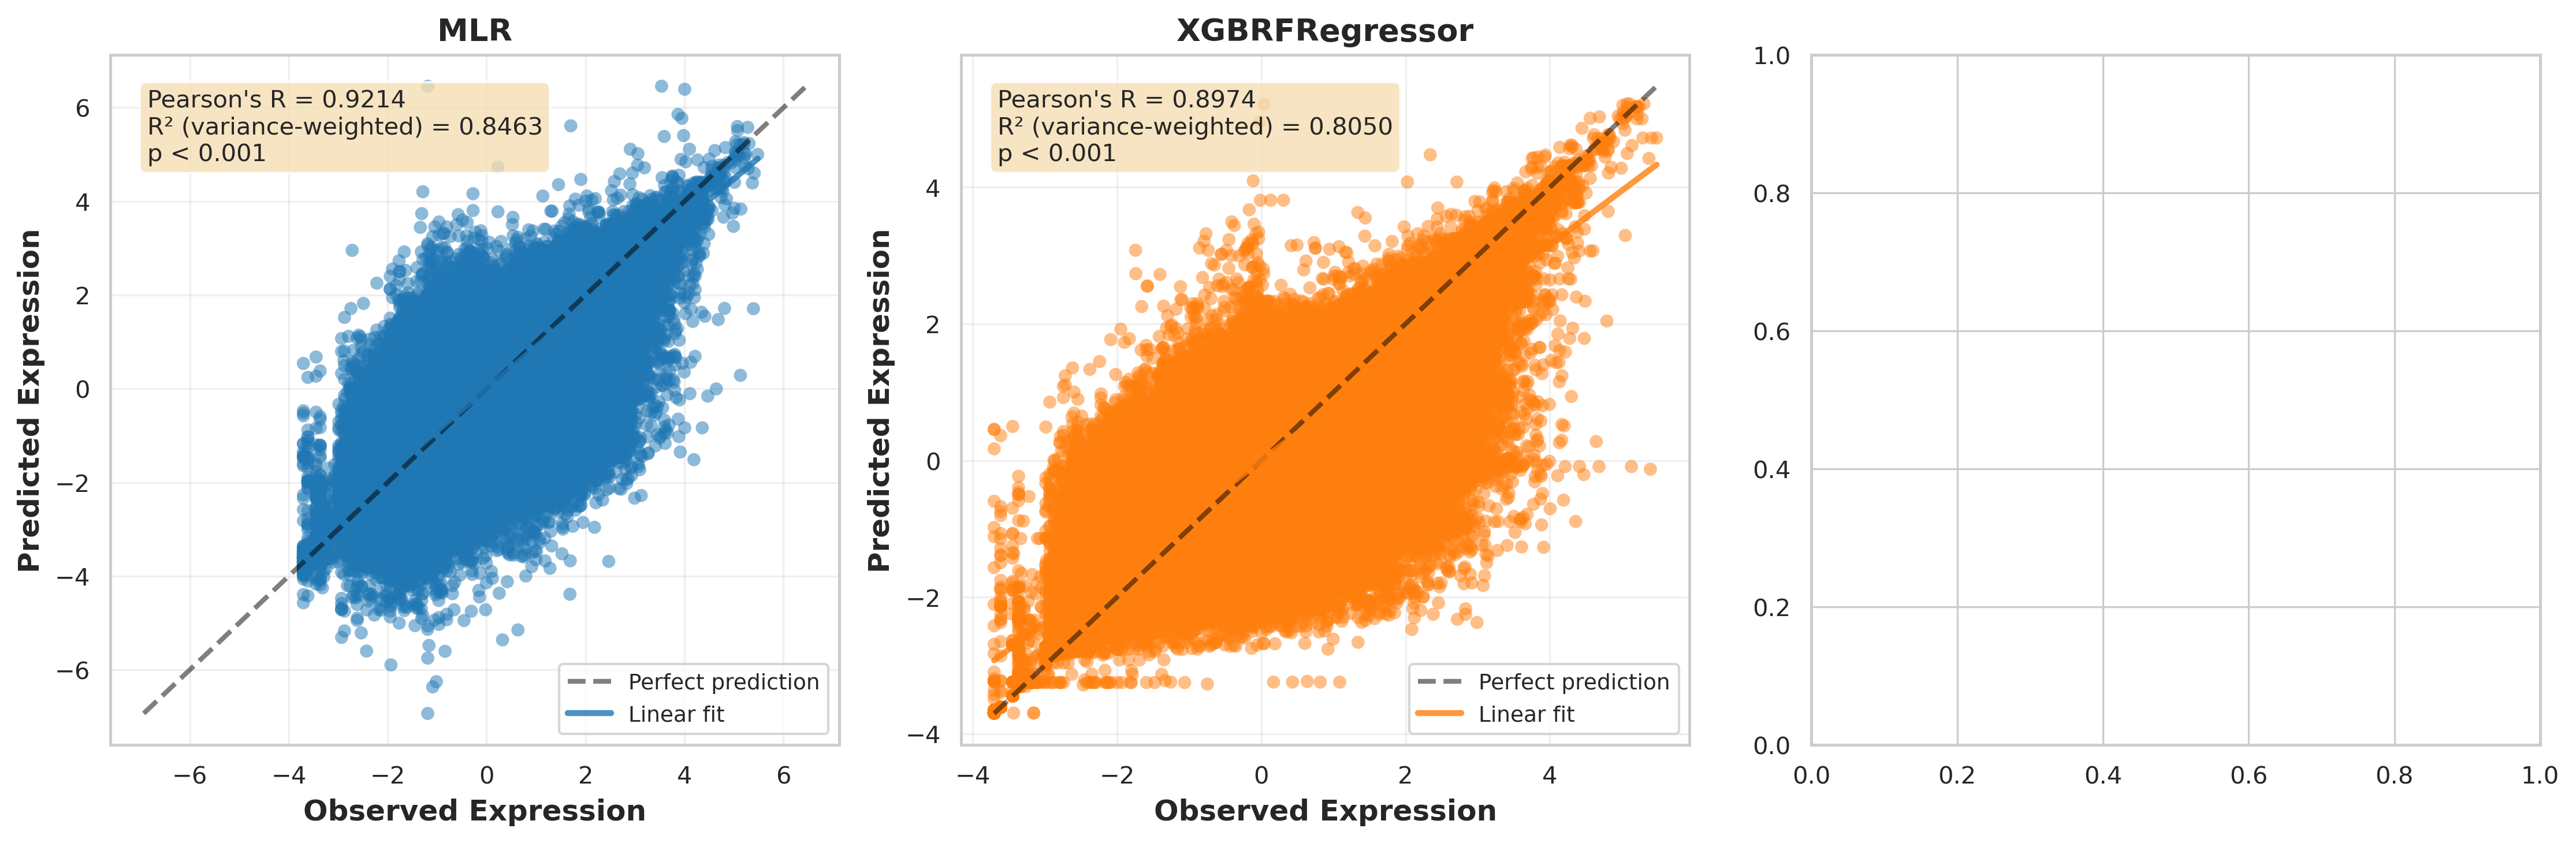

{'MLR': {'pearson_r': np.float64(0.921374952363722),
  'p_value': np.float64(0.0),
  'r2_variance_weighted': 0.8463157210258276,
  'r2_uniform_average': 0.7934193600256717,
  'rmse': np.float64(0.17686590467868266),
  'mae': 0.09796217047446705},
 'XGBRFRegressor': {'pearson_r': np.float64(0.8973899726475706),
  'p_value': np.float64(0.0),
  'r2_variance_weighted': 0.8050248679702268,
  'r2_uniform_average': 0.7599449659557176,
  'rmse': np.float64(0.19921361181401329),
  'mae': 0.11759603980856798}}

In [ ]:
# XGBRF was trained on x_test not x_test_centered so needs to be retrained for real interpretable results
# Retrained XGBRF on centered data, redone and resaved as "fig1_centered"
figure_1_observed_vs_predicted(y_test_centered,predictions,r2_method='variance_weighted', output_path = 'figure1_v4(uncentered/FINAL).png')